In [1]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro
#!pip install git+https://github.com/mwaskom/seaborn.git
!pip install -U matplotlib

  Preparing metadata (setup.py) ... done


In [2]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
import sys
import json
import pandas as pd

sys.path.append('drive/MyDrive/user-mod-alignment/practice_analysis/preprocessing/')
sys.path.append('drive/MyDrive/user-mod-alignment/practice_analysis/viz/')
sys.path.append('drive/MyDrive/user-mod-alignment/practice_analysis/models/')

Mounted at /content/drive/


#Preprocessing Data#

#### Load in survey response data from all_user_mod.json. This file contains an entry for each comment included in the user survey. We convert this to a pandas dataframe that contains an entry for each decider-comment pair in the dataset. i.e. a given comment will have one entry for the IRL moderation decision made for it, two entries for each survey decision made by a momderator, and one entry for each user assigned the comment in the user survey. **To run the code as written, please copy the user-mod-alignment folder into your personal drive!** ####



In [3]:
from preprocess import gen_dataset, load_pop_df
dataset, user_map, mod_survey_map = gen_dataset("/content/drive/My Drive/user-mod-alignment/practice.json")

### Count the number of disagreements between moderators who took the moderator survey

In [4]:
#Count number of disagreements
import math
disagreed_ids = set()
all_ids = set()
for _id in dataset._id:
    mod_survey1 = "{}mod_survey1".format(_id)
    mod_survey2 = "{}mod_survey2".format(_id)
    if mod_survey1 in dataset.index and mod_survey2 in dataset.index:
        dec1 = dataset[dataset.index == mod_survey1]["mod_decision"].item()
        dec2 = dataset[dataset.index == mod_survey2]["mod_decision"].item()
        if not math.isnan(dec1) and not math.isnan(dec2):
            all_ids.add(_id)
            if dec1 != dec2:
                disagreed_ids.add(_id)
print(len(disagreed_ids))
print(len(all_ids))

21
132


In [5]:
print(dataset)

                        _id  user_opinion  user_perception  user_application  \
8G1OOASuser1        8G1OOAS           1.0              1.0               2.0   
8G1OOASmod_survey1  8G1OOAS           NaN              NaN               NaN   
8G1OOASmod_survey2  8G1OOAS           NaN              NaN               NaN   
8G1OOASmod_irl      8G1OOAS           NaN              NaN               NaN   
0NTQA3Wuser1        0NTQA3W           0.0              0.0               0.0   
...                     ...           ...              ...               ...   
N188HC2mod_irl      N188HC2           NaN              NaN               NaN   
JRKFCQ7mod_irl      JRKFCQ7           NaN              NaN               NaN   
3FQBLUAmod_irl      3FQBLUA           NaN              NaN               NaN   
F26T29Mmod_irl      F26T29M           NaN              NaN               NaN   
O9WY33Cmod_irl      O9WY33C           NaN              NaN               NaN   

                    comment_index  user

#Plot Raw Data#

####This is the Figure 8 in the main paper plus figures 2 and 3 in the supplement.####

In [6]:
from gen_heatmap import gen_all_heatmaps

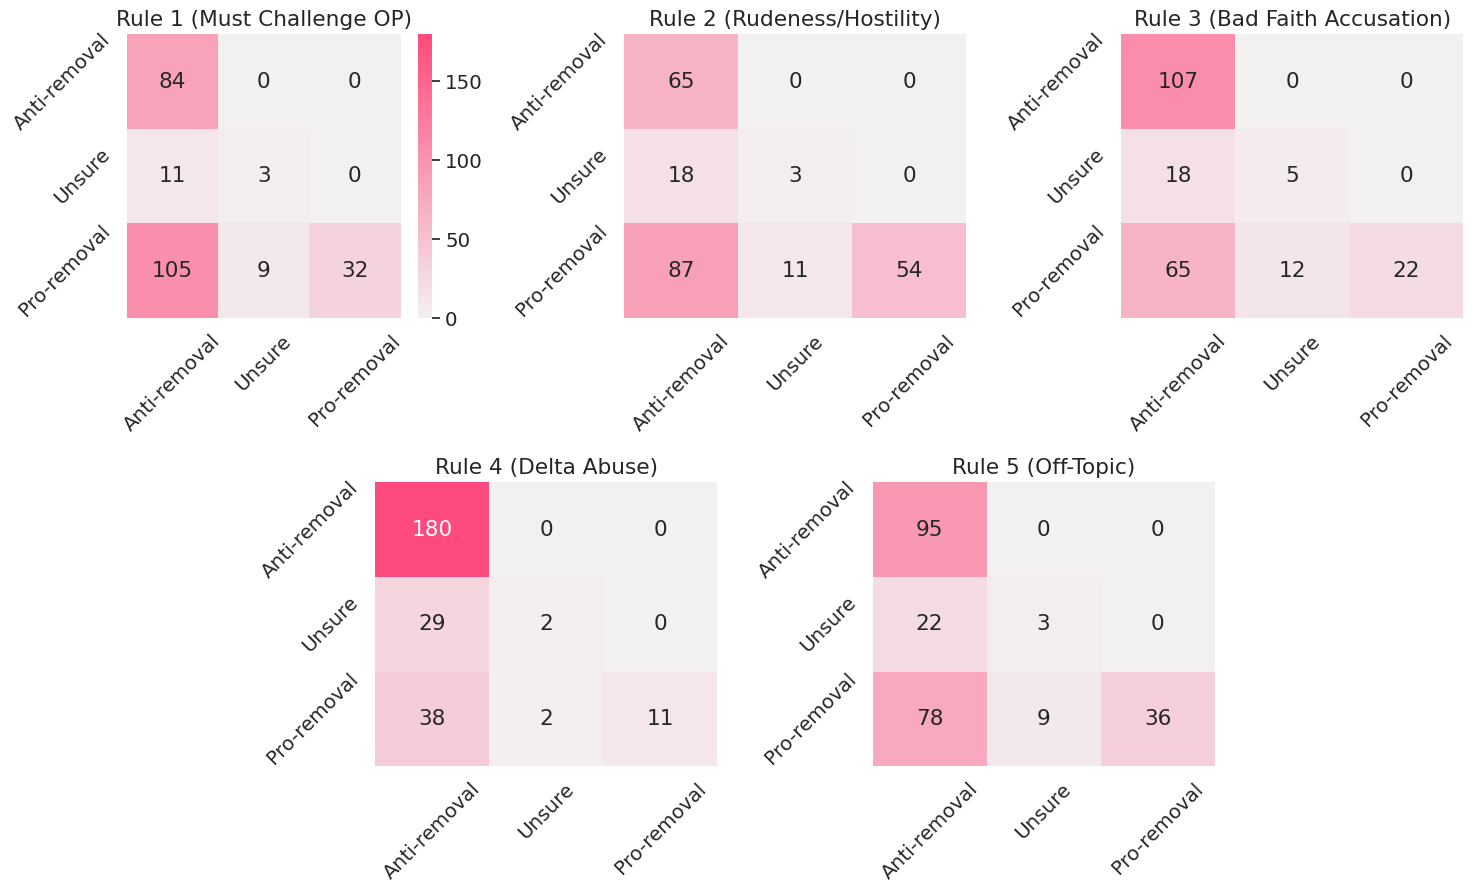

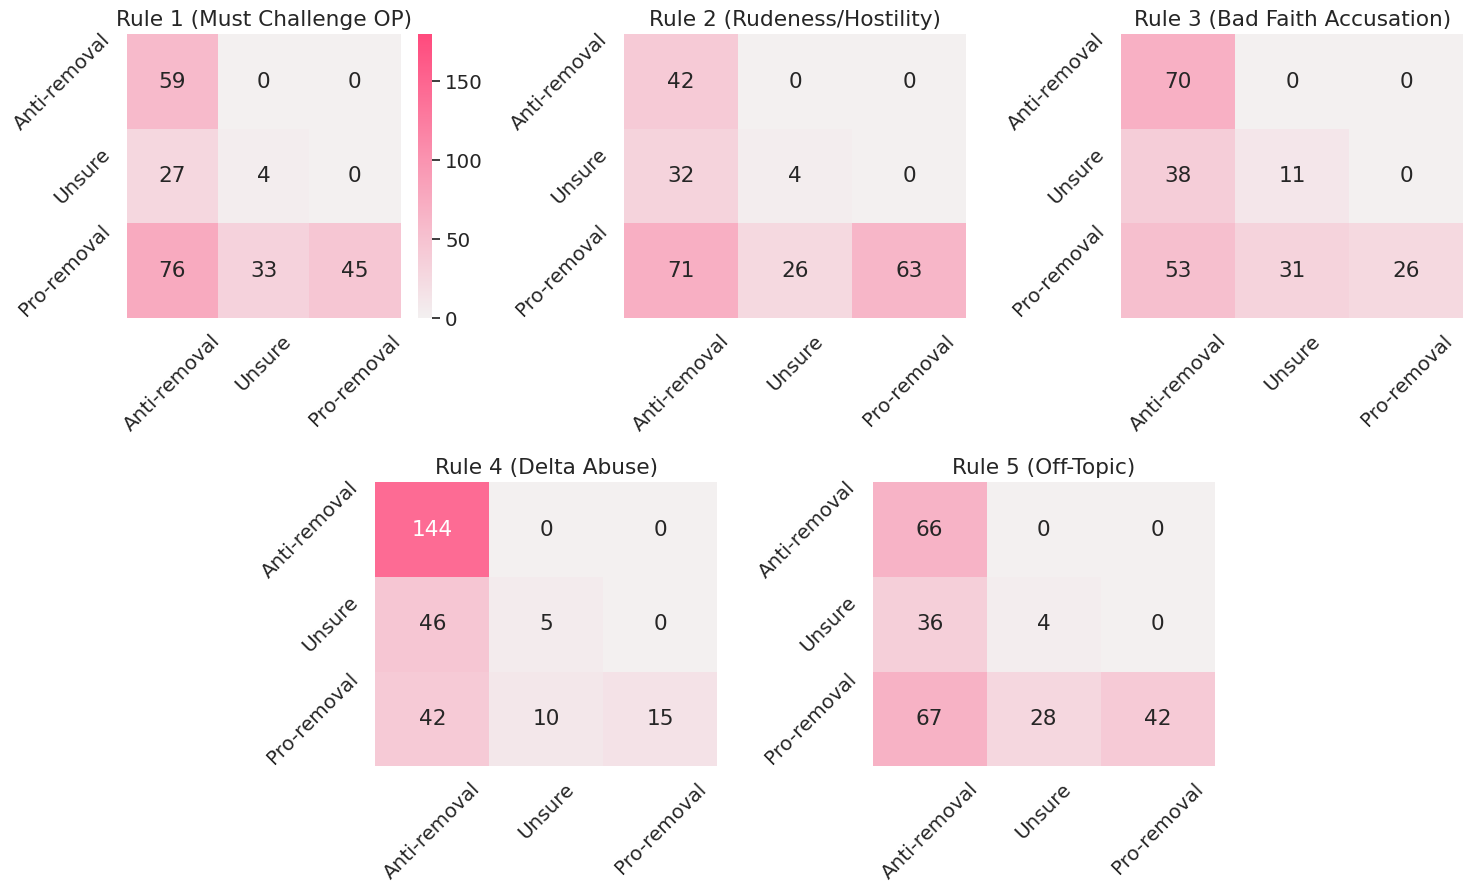

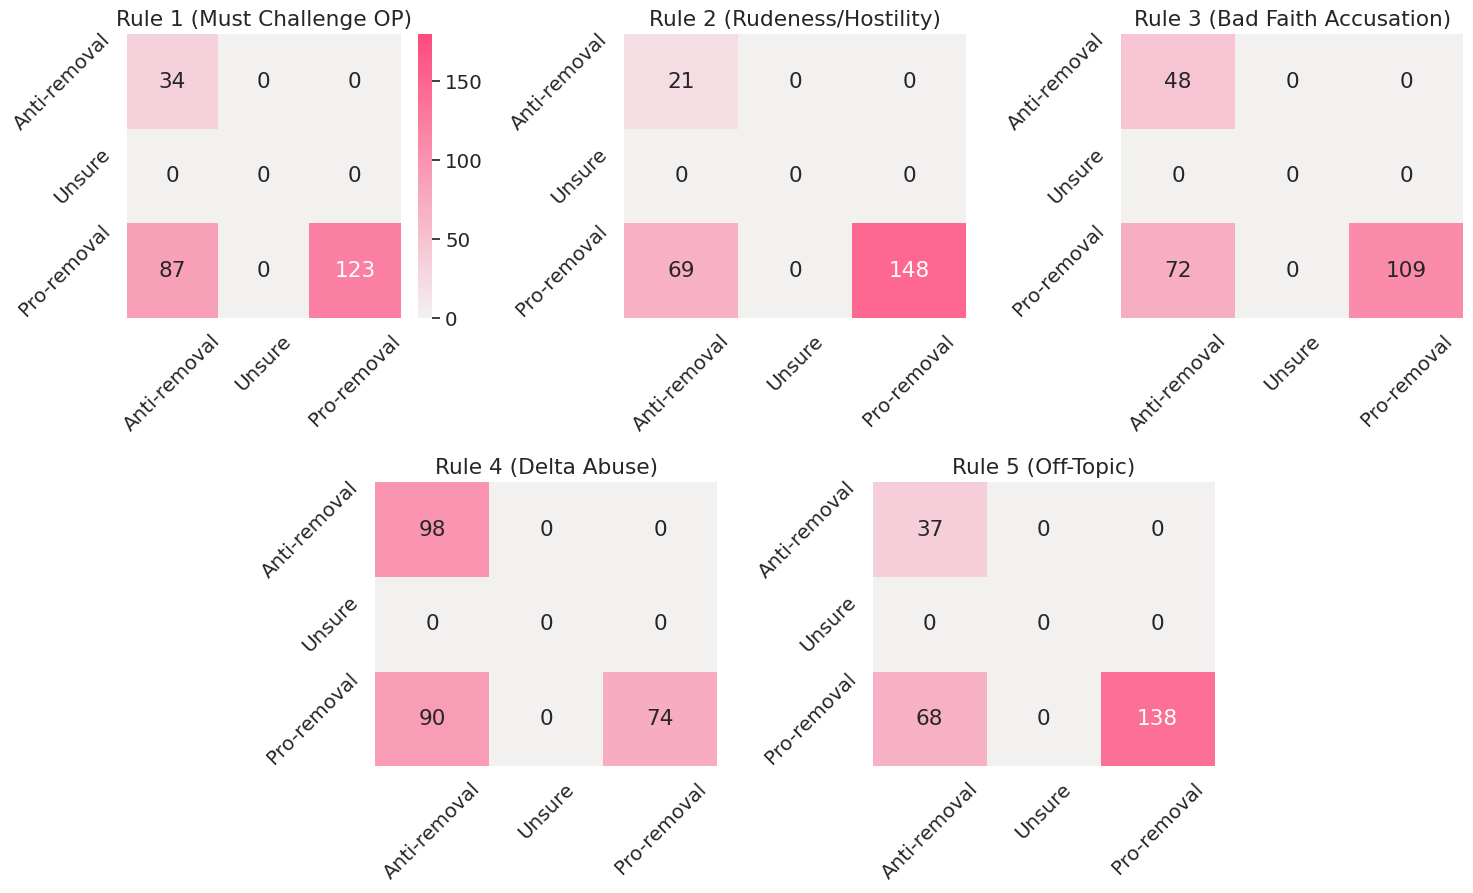

In [8]:
gen_all_heatmaps(dataset, "user_opinion", "/content/")
gen_all_heatmaps(dataset, "user_perception", "/content/")
gen_all_heatmaps(dataset, "user_application", "/content/")


In [9]:
!cp /content/user-op-heatmap.pdf /content/drive/MyDrive/user-mod/figures/user-op-heatmap.pdf

### Contrasts user survey responses with actual decision made for surveyed comments. Note that to make the association between user- and mod-decisions clearer, this only includes comments which had exactly two users assigned to them. Some comments had 1 or 3+ users assigned to them -- these are still used to fit our model. ###

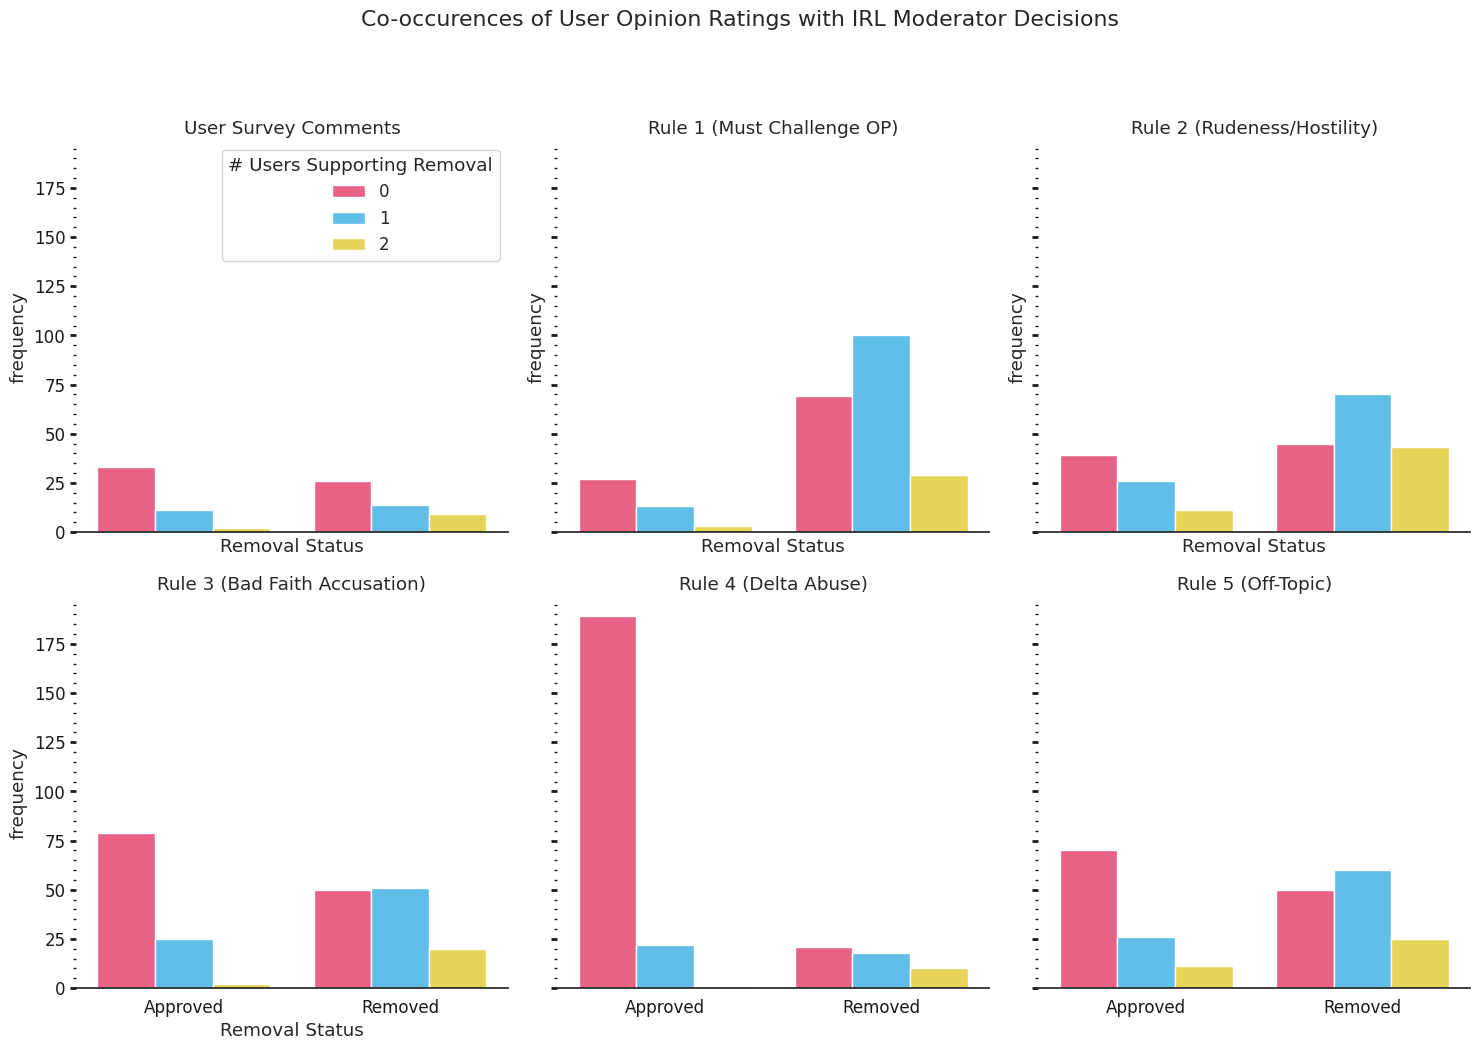

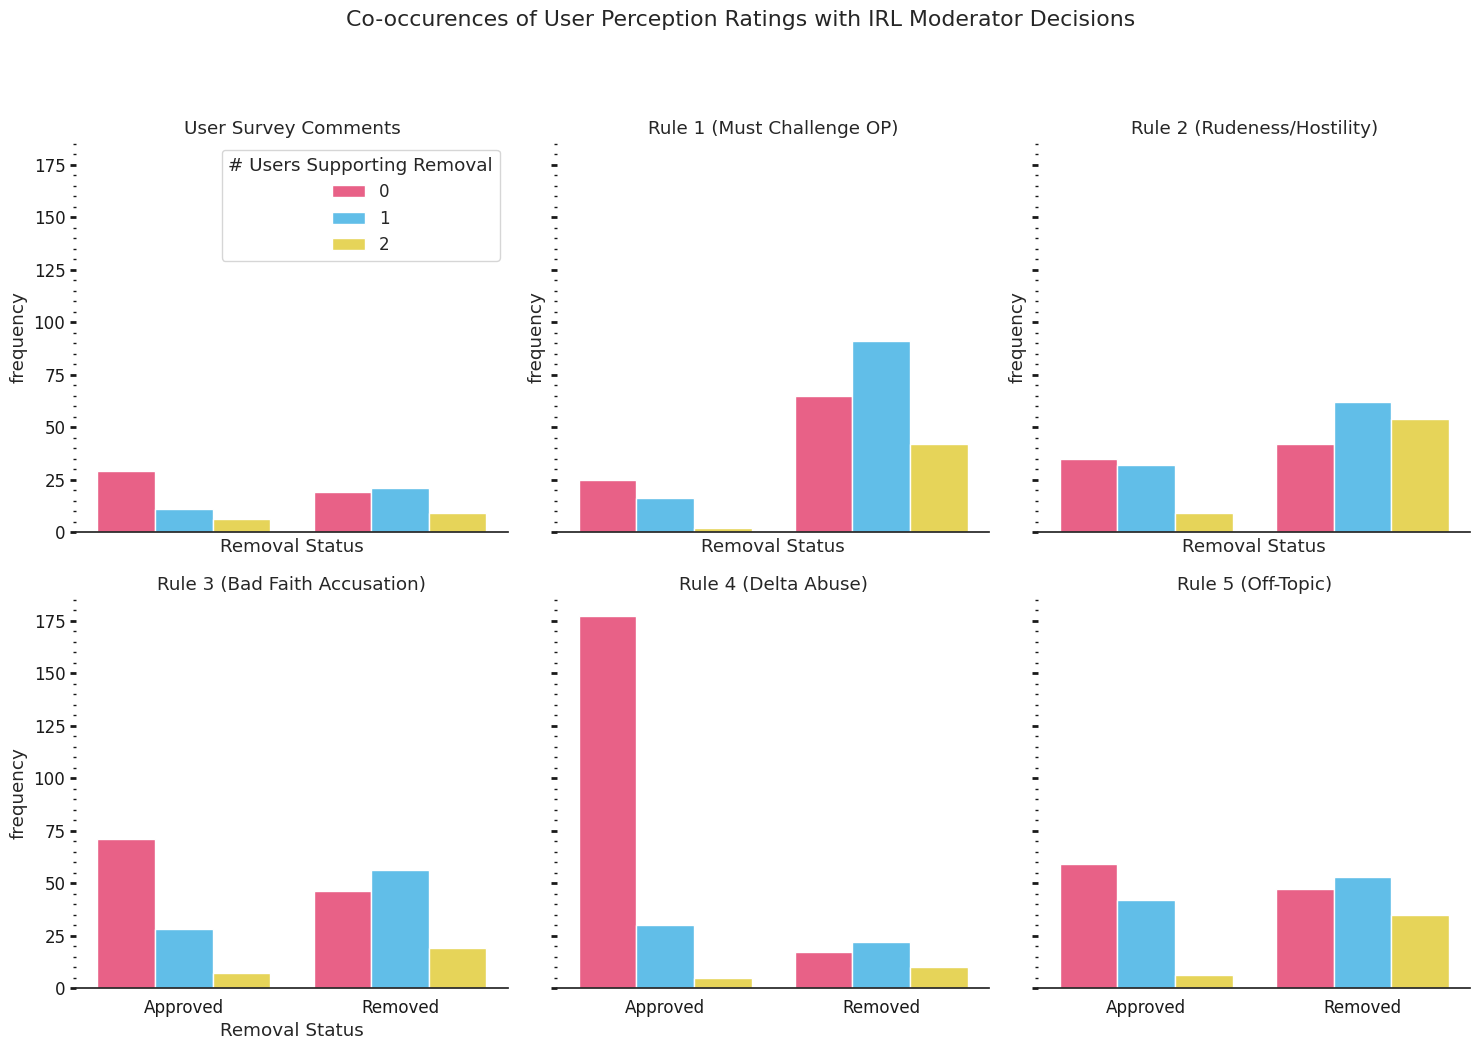

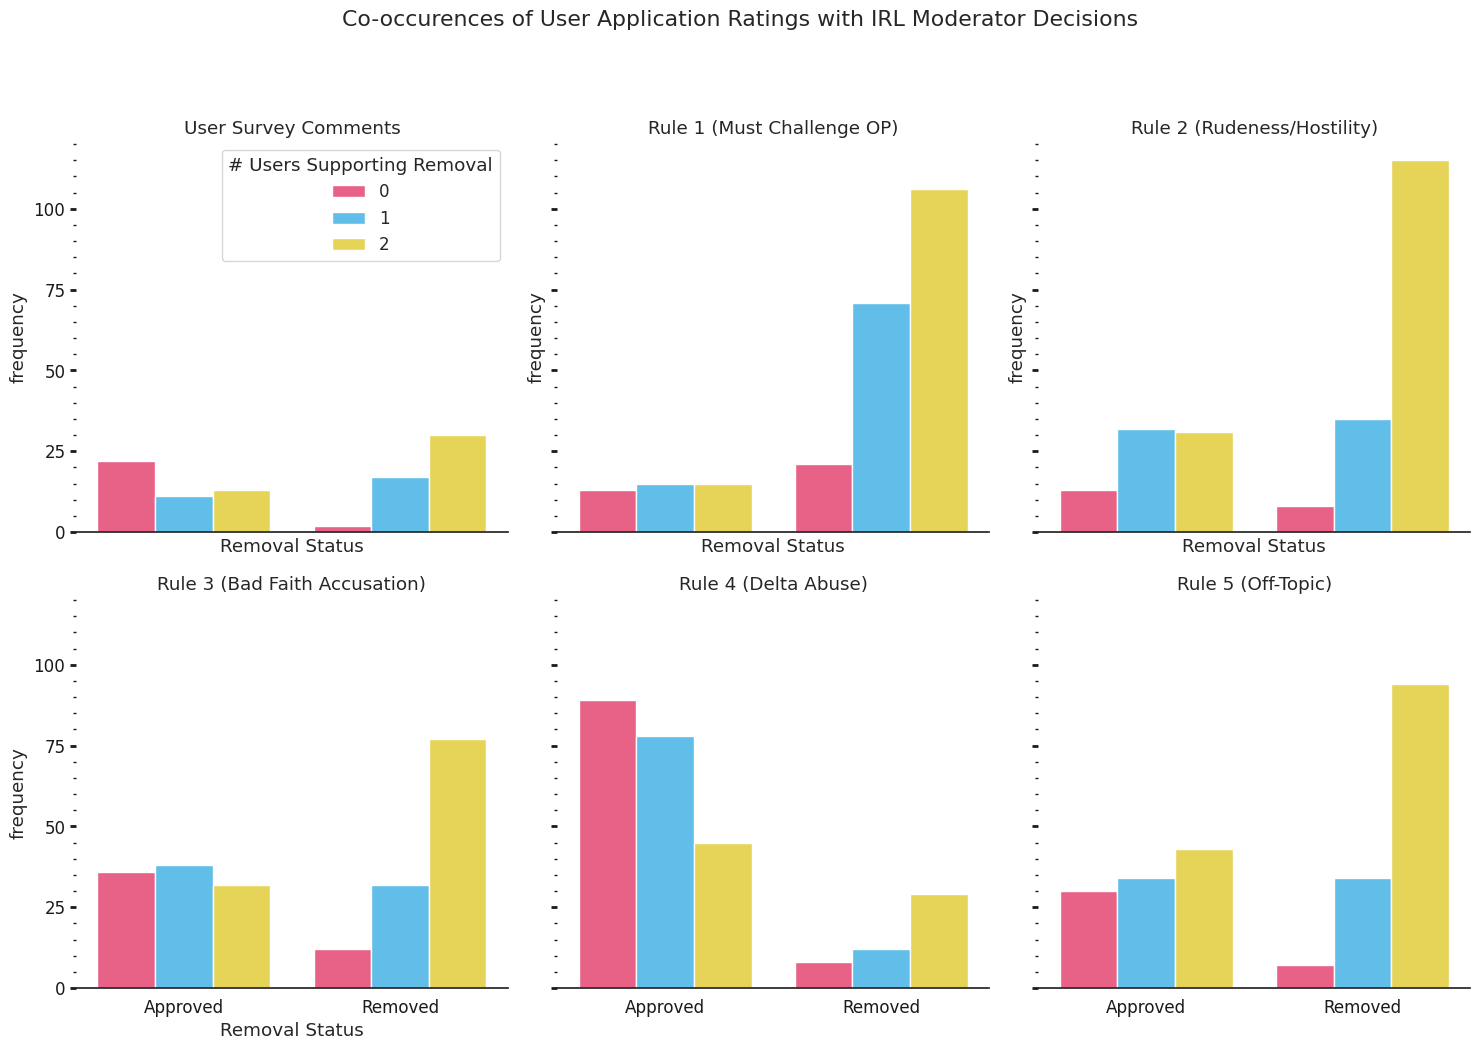

In [ ]:
from user_mod_bars import gen_user_mod_bars

gen_user_mod_bars(dataset, "user_opinion", "/content/")
gen_user_mod_bars(dataset, "user_perception", "/content/")
gen_user_mod_bars(dataset, "user_application", "/content/")

### Counts how often the two users assigned to a comment in the user-survey agreed over the comment outcome. ###

In [ ]:
user_agree = 0
total = 0
seen_ids = set()
users = dataset[(dataset["user"] == True)]
for _id in users._id.values:
    cur_users = dataset[(dataset["user"] == True) & (dataset["_id"] == _id)]
    if len(cur_users) > 1 and _id not in seen_ids:
        user_0 = cur_users.user_opinion[0]
        user_1 = cur_users.user_opinion[1]
        if (user_0 == 0.0 and user_1 == 0.0) or (user_0 == 2.0 and user_1 == 2.0):
            user_agree += 1
        total += 1
        seen_ids.add(_id)
print(user_agree)
print(total)


747
1316


#Model w/out Response Bias Adjustment#

#### This model is described in equation 1 of section 4.2 of the paper ####

In [ ]:
from no_adj_model import run_model_MU

In [ ]:
cor_model = run_model_MU(dataset, user_map, mod_survey_map)


/content/drive/MyDrive/user-mod-alignment/practice_analysis/models/no_adj_model.py:139: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  cor_model = MCMC(NUTS(correlation_model_MU, target_accept_prob = .9), num_warmup=1000, num_samples=2000, num_chains=4, chain_method="parallel", progress_bar=True)
sample: 100%|██████████| 3000/3000 [13:32<00:00,  3.69it/s, 63 steps of size 5.59e-02. acc. prob=0.90]


In [ ]:
import arviz as az
inf_data = az.from_numpyro(cor_model)
cor_model.print_summary()

Streaming output truncated to the last 5000 lines.
  tendency_z_4[1,6]     -0.03      0.96     -0.02     -1.62      1.49   7930.24      1.00
  tendency_z_4[1,7]     -0.14      0.94     -0.13     -1.66      1.44  10672.96      1.00
  tendency_z_4[1,8]      0.34      0.96      0.35     -1.24      1.91   4129.96      1.00
  tendency_z_4[1,9]      0.48      0.94      0.50     -1.05      2.03   5595.43      1.00
 tendency_z_4[1,10]     -0.07      0.96     -0.06     -1.64      1.53   7449.56      1.00
 tendency_z_4[1,11]     -0.05      0.95     -0.04     -1.60      1.52  11211.01      1.00
 tendency_z_4[1,12]      0.04      1.00      0.05     -1.62      1.68   3686.83      1.00
 tendency_z_4[1,13]     -0.00      0.96     -0.01     -1.59      1.56  10127.24      1.00
 tendency_z_4[1,14]      0.01      0.97      0.01     -1.63      1.57   5350.60      1.00
 tendency_z_4[1,15]     -0.07      0.96     -0.08     -1.63      1.53  11760.12      1.00
 tendency_z_4[1,16]     -0.00      0.98      0.00

### Here we compute and plot the measures described in sections 5.3.1 and 5.3.2 of the paper. These are: 1. the correlation between the latent probability of observing a positive label for each comment in different decision contexts and the IRL moderation decision made. 2. the average probability of observinga positive label in different decision-making contexts ###

In [ ]:
from no_adj_model import posterior_analysis

empirical_corrs, empirical_means = posterior_analysis(cor_model, dataset, user_map, mod_survey_map, pb=True)

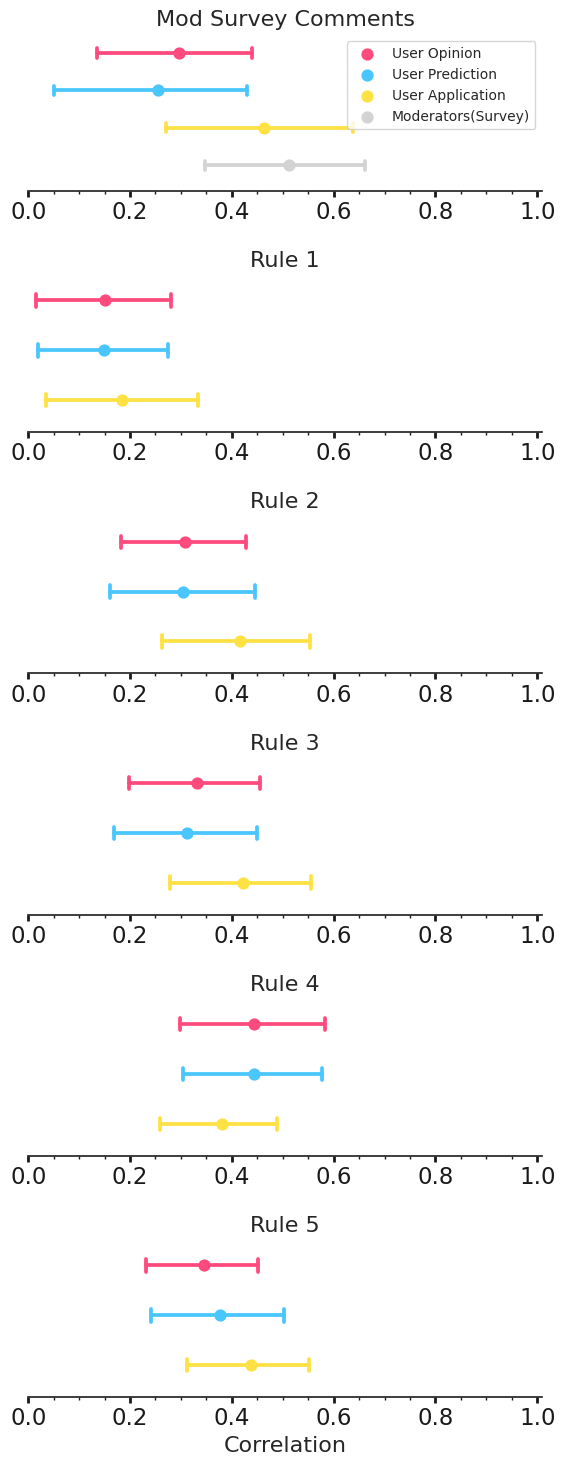

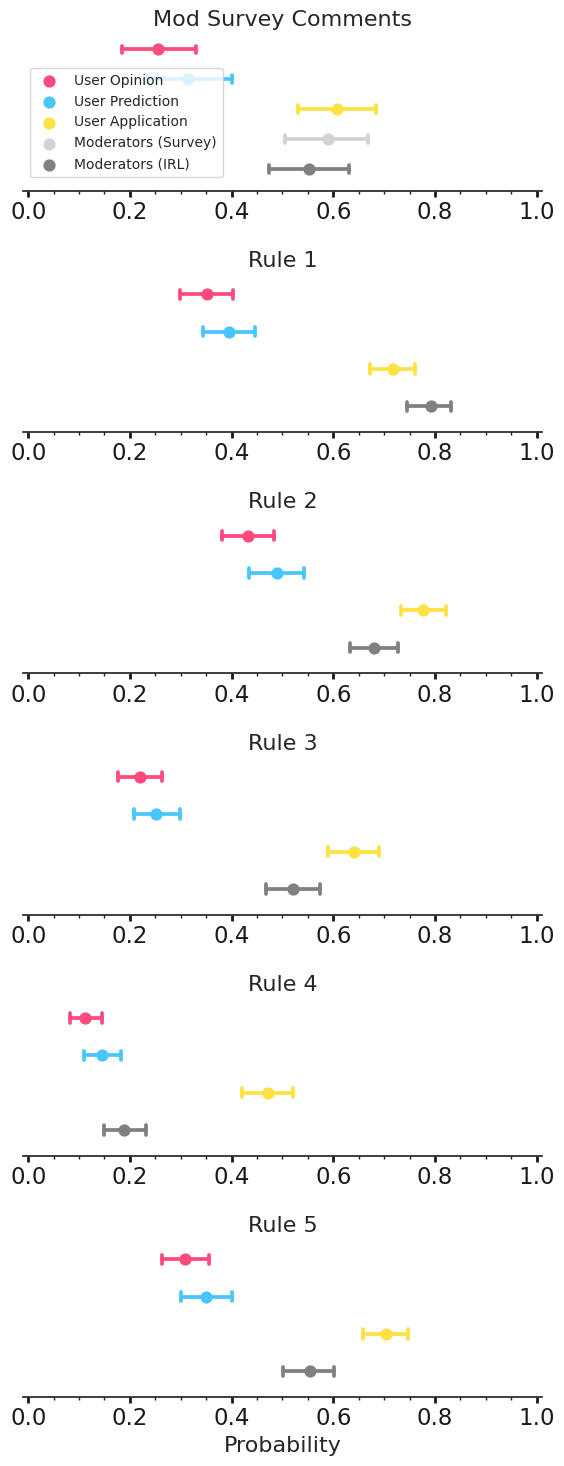

In [ ]:
from pointplots import plot_corrs, plot_means

plot_corrs(empirical_corrs, "/content/removal-corr.pdf")
plot_means(empirical_means, "/content/removal-prob.pdf")

### Plots the posterior predictive checks to assess model fit described in section A4 of the main paper ###


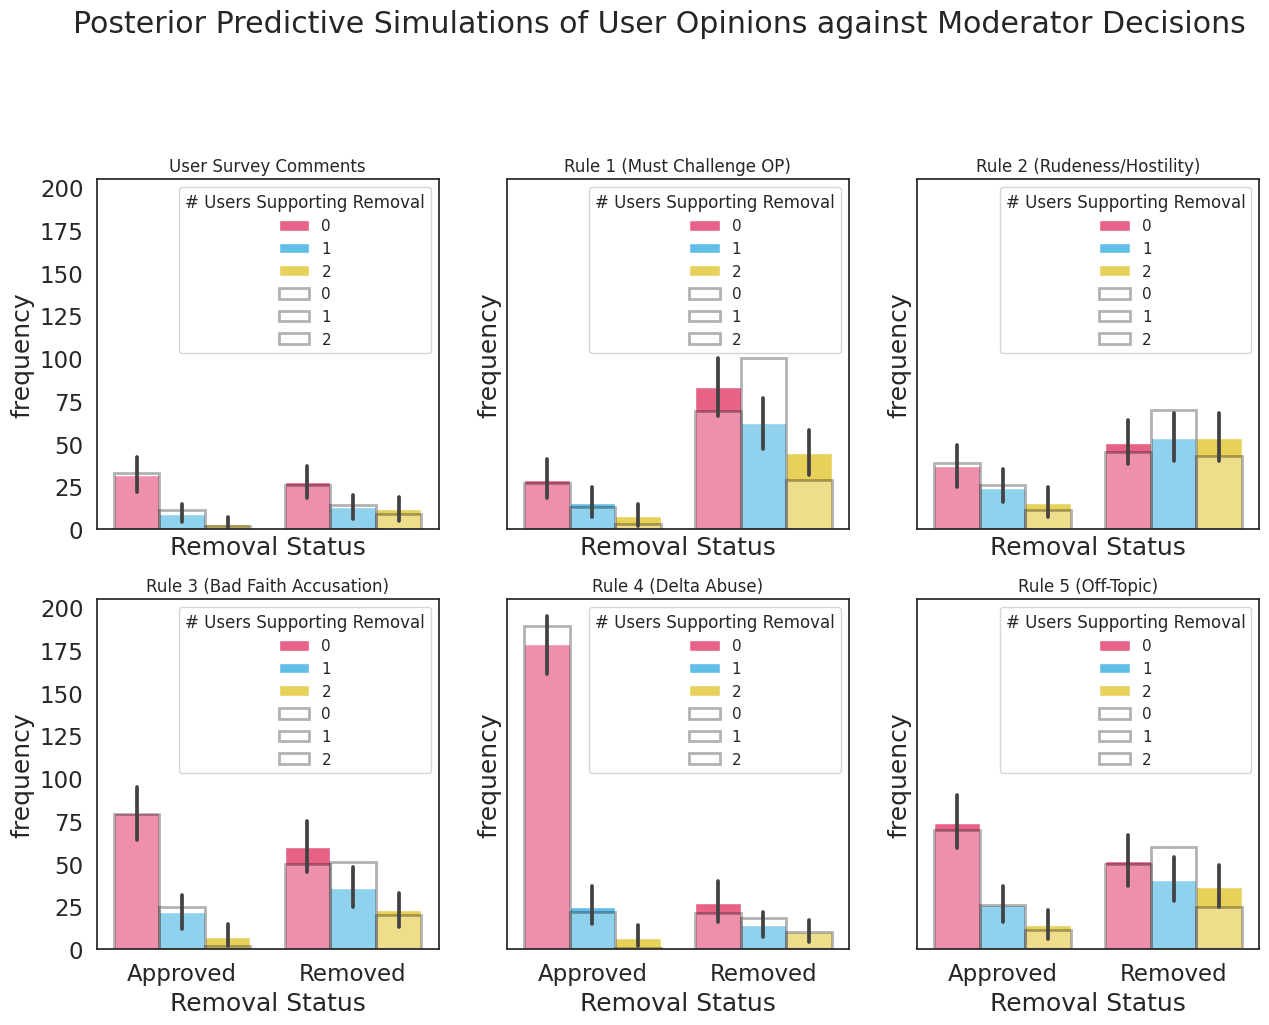

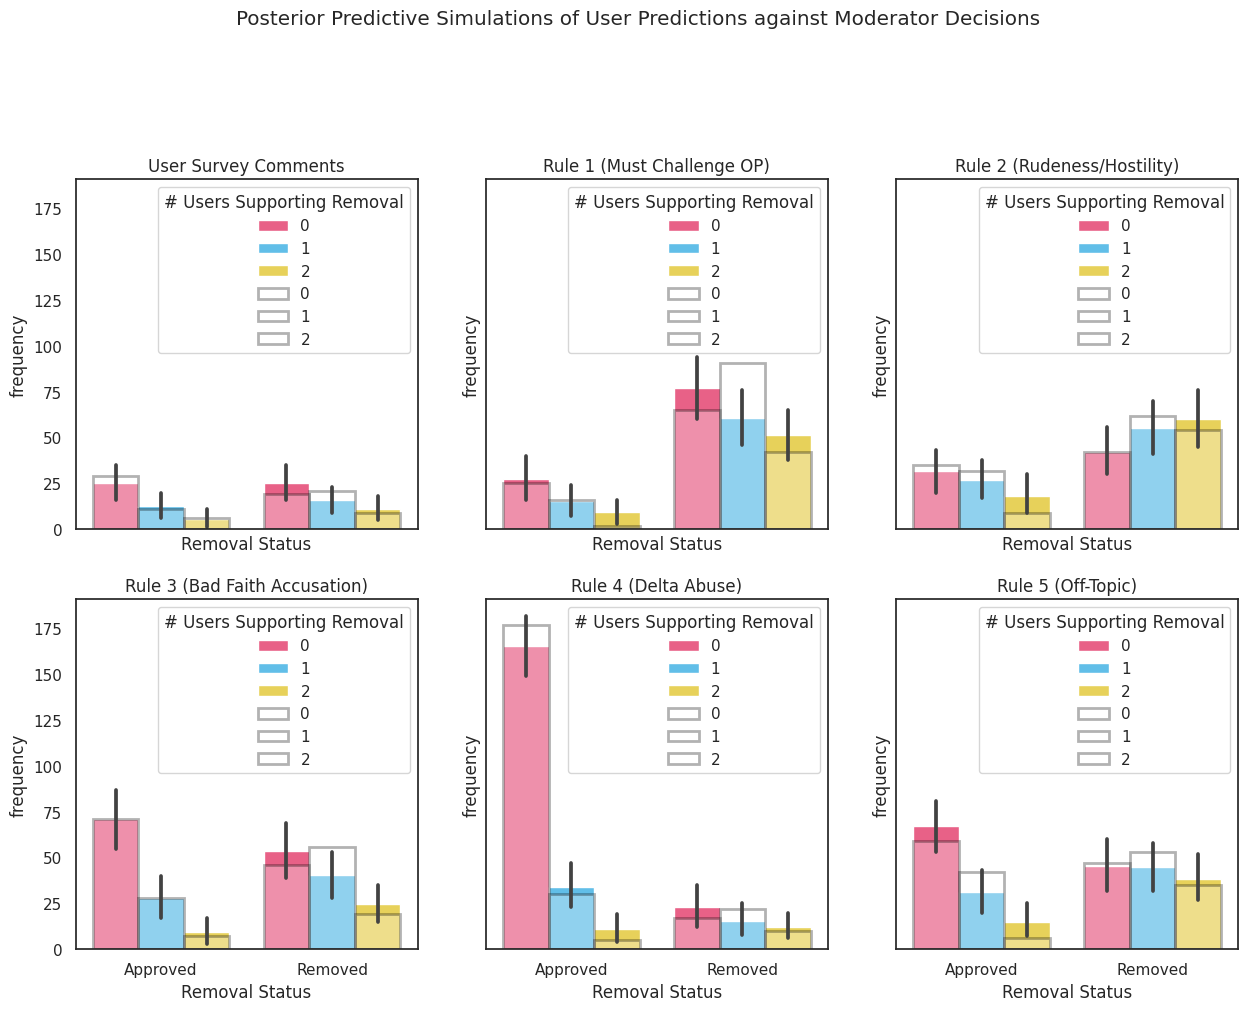

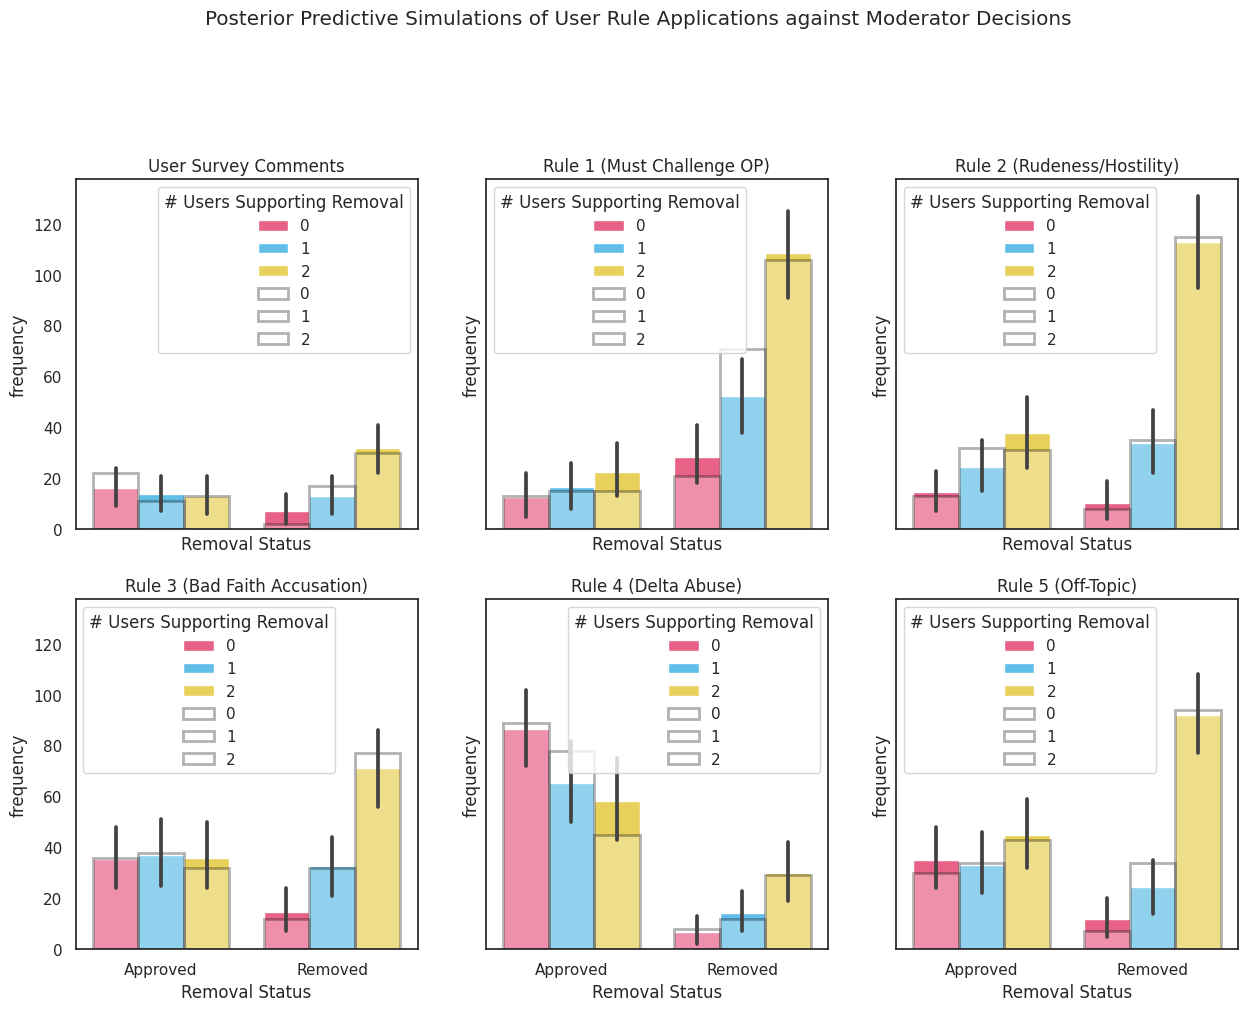

In [ ]:
from posterior_predictive import plot_all
plot_all(dataset, inf_data, "user_opinion", "/content/drive/My Drive/user-mod/figures/")
plot_all(dataset, inf_data, "user_perception", "/content/drive/My Drive/user-mod/figures/")
plot_all(dataset, inf_data, "user_application", "/content/drive/My Drive/user-mod/figures/")

#Model w/ Response Bias Adjustment#

#### This mode is described in sections 4.3.3 and A.3.2 of the main paper ####

In [ ]:
from adj_model import run_model_MU_adjusted, posterior_analysis_adjusted, correlation_model_MU_adjusted
from preprocess import load_pop_df

cor_model, means, stds = run_model_MU_adjusted(dataset, user_map, mod_survey_map, adjustment=True)
pd.options.display.max_rows = 4000

/content/drive/MyDrive/user-mod-alignment/practice_analysis/models/adj_model.py:470: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  cor_model = MCMC(NUTS(correlation_model_MU_adjusted, target_accept_prob = .9), num_warmup=1000, num_samples=2000, num_chains=4, chain_method="parallel", progress_bar=True)
sample:  45%|████▍     | 1348/3000 [35:32<42:08,  1.53s/it, 511 steps of size 7.18e-03. acc. prob=0.96]

In [ ]:
import arviz as az
inf_data = az.from_numpyro(cor_model)
az.summary(inf_data, var_names=["age_slope", "com_gen_slope", "com_sub_slope", "rem_gen_slope", "rem_sub_slope", "mod_slope"])

### Note that to conduct response bias adjustment, we need to have a sample of our adjustment variables in the population we want to correct against. Here, we load into pop_df a sample of these variables for ~1200 users who received a survey link, regardless of whether they responded or not. ###

In [ ]:
pop_df = load_pop_df("/content/drive/My Drive/user-mod/population_participation.json", means, stds)
empirical_corrs_adj, empirical_means_adj = posterior_analysis_adjusted(cor_model, dataset, user_map, mod_survey_map, pop_df, pb=True)

### Plots the practice-awareness and -support measures across decision contexts, adjusting for the participation variables described in section 3.3.2 of the paper. This is figures ###

In [ ]:
from pointplots import plot_corrs, plot_means


plot_corrs(empirical_corrs_adj, "/content/drive/My Drive/user-mod/figures/adjusted-removal-corr.pdf")
plot_means(empirical_means_adj, "/content/drive/My Drive/user-mod/figures/adjusted-removal-prob.pdf")